In [1]:
# Referenced: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [2]:
# Fixing seed to get same result
tf.random.set_seed(8)
stockPrices = yf.download("C", start="2018-01-01")
stockPrices = stockPrices.dropna()
stockPrices = stockPrices.reset_index()
stockPrices = stockPrices.rename(columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Adj Close": "adjClose", "Volume": "volume"})
stockPrices = stockPrices.drop(columns=["open", "high", "low", "close", "volume"])

print(stockPrices.head())

[*********************100%%**********************]  1 of 1 completed

        date   adjClose
0 2018-01-02  59.538170
1 2018-01-03  59.722336
2 2018-01-04  60.458950
3 2018-01-05  60.378880
4 2018-01-08  59.674263


In [14]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = stockPrices['adjClose']
dataset = scaler.fit_transform(pd.DataFrame(dataset))

<class 'numpy.ndarray'>


In [13]:
# Split into training and test data sets
trainSize = int(len(dataset) * 0.67)
testSize = len(dataset) - trainSize

# Indexing by rows I believe

print("dataset")
print(type(dataset))
trainingData = dataset[0:trainSize,:]
testData = dataset[trainSize:len(dataset),:]

print("split data, training")
print(trainingData)

print("split data, test")
print(testData)
# print(len(trainingData), len(testData))

dataset
<class 'numpy.ndarray'>
split data, training
[[0.72027383]
 [0.72476229]
 [0.7427149 ]
 ...
 [0.39702542]
 [0.38971065]
 [0.38505587]]
split data, test
[[0.38084419]
 [0.39813363]
 [0.42872268]
 [0.44224383]
 [0.44623368]
 [0.43581581]
 [0.40478348]
 [0.40256677]
 [0.38261752]
 [0.36865299]
 [0.37796264]
 [0.34885007]
 [0.36004713]
 [0.39117541]
 [0.43887502]
 [0.41827237]
 [0.4252146 ]
 [0.38647247]
 [0.360943  ]
 [0.33653318]
 [0.31189958]
 [0.33608534]
 [0.33205439]
 [0.41244987]
 [0.37370773]
 [0.38400901]
 [0.3833372 ]
 [0.45096804]
 [0.44895243]
 [0.44940046]
 [0.48052855]
 [0.4700032 ]
 [0.46530036]
 [0.44245822]
 [0.44335399]
 [0.41872021]
 [0.42028788]
 [0.43596391]
 [0.42051176]
 [0.38826402]
 [0.33765292]
 [0.29241639]
 [0.29846304]
 [0.33474181]
 [0.31928957]
 [0.3110038 ]
 [0.34325154]
 [0.32623199]
 [0.30719683]
 [0.34101206]
 [0.34034016]
 [0.32645577]
 [0.32399241]
 [0.29913484]
 [0.31884172]
 [0.31301941]
 [0.30271795]
 [0.32018553]
 [0.31772207]
 [0.30361363]


In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
 
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 8
trainX, trainY = create_dataset(trainingData, look_back)
testX, testY = create_dataset(testData, look_back)

print(trainX, trainY)

[[0.72027383 0.72476229 0.7427149  ... 0.73881188 0.74544657 0.74369016]
 [0.72476229 0.7427149  0.74076343 ... 0.74544657 0.74369016 0.76866803]
 [0.7427149  0.74076343 0.72359067 ... 0.74369016 0.76866803 0.77393689]
 ...
 [0.50874172 0.5209331  0.48768425 ... 0.43958392 0.41254154 0.38926736]
 [0.5209331  0.48768425 0.45288371 ... 0.41254154 0.38926736 0.37818429]
 [0.48768425 0.45288371 0.42916606 ... 0.38926736 0.37818429 0.39702542]] [0.76866803 0.77393689 0.78096224 ... 0.37818429 0.39702542 0.38971065]


In [6]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX)
print(testX)

[[[0.72027383 0.72476229 0.7427149  ... 0.73881188 0.74544657 0.74369016]]

 [[0.72476229 0.7427149  0.74076343 ... 0.74544657 0.74369016 0.76866803]]

 [[0.7427149  0.74076343 0.72359067 ... 0.74369016 0.76866803 0.77393689]]

 ...

 [[0.50874172 0.5209331  0.48768425 ... 0.43958392 0.41254154 0.38926736]]

 [[0.5209331  0.48768425 0.45288371 ... 0.41254154 0.38926736 0.37818429]]

 [[0.48768425 0.45288371 0.42916606 ... 0.38926736 0.37818429 0.39702542]]]
[[[0.38084419 0.39813363 0.42872268 ... 0.43581581 0.40478348 0.40256677]]

 [[0.39813363 0.42872268 0.44224383 ... 0.40478348 0.40256677 0.38261752]]

 [[0.42872268 0.44224383 0.44623368 ... 0.40256677 0.38261752 0.36865299]]

 ...

 [[0.81244381 0.81756186 0.8143936  ... 0.83242867 0.83072265 0.80854432]]

 [[0.81756186 0.8143936  0.8190242  ... 0.83072265 0.80854432 0.84705171]]

 [[0.8143936  0.8190242  0.83486581 ... 0.80854432 0.84705171 0.8246297 ]]]


In [7]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))

# Adds a neural network layer with one input
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

c:\Users\isss1\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1069/1069 - 2s - 2ms/step - loss: 0.0381
Epoch 2/5
1069/1069 - 1s - 974us/step - loss: 0.0022
Epoch 3/5
1069/1069 - 1s - 892us/step - loss: 0.0018
Epoch 4/5
1069/1069 - 1s - 880us/step - loss: 0.0015
Epoch 5/5
1069/1069 - 1s - 920us/step - loss: 0.0014


In [8]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions to original units to compute error in actual units of original dataset
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 2.30 RMSE
Test Score: 2.02 RMSE


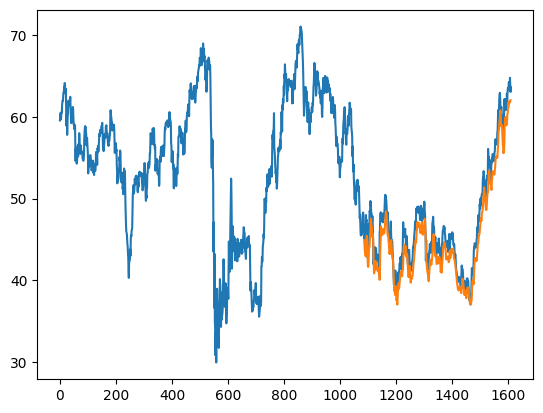

In [12]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()